# Telstra Network Disruptions

In [119]:
##############
# basic libs #
##############

from tqdm import *
import warnings
import os, sys, time, datetime, json, string, glob, re
warnings.filterwarnings('ignore')

############
# plumbing #
############

from sqlalchemy import create_engine
from collections import OrderedDict
import urllib2, requests, operator, hashlib, uuid

###########
# science #
###########

from math import radians, cos, sin, asin, sqrt
from scipy import integrate, stats, interp
from scipy.spatial import distance
import numpy as np
import pandas as pd
import pymc3 as pm
import theano as thno
import theano.tensor as T

#################
# visualization #
#################

# plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='pearl')
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))

# matplotlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# seaborn
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

#graphistry
import graphistry
graphistry.register(key=os.environ.get('GRAPHISTRY_APIKEY'))

########
# data #
########

datadir = '/home/kcavagnolo/ml_fun/telstra/data/'
files = sorted(glob.glob(datadir+'*.csv'))

## What's the problem?

* Informal: using Telstra's service logs, the task is to predict the severity of a network disruption.

* Describe the problem formally, e.g.
    * Task (T): For a specific time and location, classify network fault severity as 0 == no faults, 1 == few faults, 2 == many faults. Fault severity is a measurement of actual reported faults from users of the network and is the target variable.
    * Experience (E): Each row in the train/test data represents a location and a time point. They are identified by the "id" column, which is the key "id" used in the other data files (event_type, resource_type, severity_type, log_feature) that contain features extracted from log files and other sources. Note that severity_type:
        * Is a categorical feature extracted from the log files
        * "Often" (**when is it not?**) the type of the warning message coming from the log files
        * Does not have an ordering
    * Performance (P): Classification accuracy, the number of fault events predicted correctly (a set of predicted probabilities one for every fault severity mus be given) out of all faults considered as a percentage.

* Assumptions:
    * All given features will matter to the model.
    * The clustering in time and location matter to the model, but may be mutually exclusive.
    * The volume of faults may not matter to the model.
    * Systemic long duration, low-volume correlated faults could be hiding in data.

* Similar problems:
    * Airline loyalty and medallion class problem
    * Anomaly detection, e.g. [Twitter's R package](https://github.com/nicolasmiller/pyculiarity)

## How should I solve this problem?
* Brainstorm! Literally type everything as a stream of consciousness (coffee helps here)

These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts.

* Describe how to solve problem manually
* What data do I have?
* What data do I need?
* What data I **don't** need?
* What do I know the least about in the solution process above?
    * knowledge gap 1
    * knowledge gap 2
* What am I concerned is incorrect in above solution? Find an expert online and ask them about these items
    * concern 1
    * concern 2

# Data Preparation

## ETL

In [65]:
# go through each file and tell me what's in it
for f in files:
    df = pd.read_csv(f)
    cols = df.columns.tolist()
    obs = df.shape[0]
    print '{:15} {:s}'.format('Filename:', f)
    print '{:15} {:d}'.format('Observations:', obs)
    for c in cols:
        uflag = ""
        nflag = ""
        uni = len(pd.unique(df[c].ravel()))
        nulls = np.count_nonzero(df[c].isnull())
        if obs != uni:
            uflag = '*MULTIPLE VALS PER KEY*'
        if nulls >0 :
            nflag = '*NULLS IN COL*'
        print '{:15} {:d} {:20} {:20}'.format(c, uni, uflag, nflag)
    print '\n'

Filename:       /home/kcavagnolo/ml_fun/telstra/data/event_type.csv
Observations:   31170
id              18552 *MULTIPLE VALS PER KEY*                     
event_type      53 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/log_feature.csv
Observations:   58671
id              18552 *MULTIPLE VALS PER KEY*                     
log_feature     386 *MULTIPLE VALS PER KEY*                     
volume          9 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/resource_type.csv
Observations:   21076
id              18552 *MULTIPLE VALS PER KEY*                     
resource_type   10 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/severity_type.csv
Observations:   18552
id              18552                                          
severity_type   5 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/t

* Column names look fine, don't need to clean those
* No nulls, hooray
* Looks like each ID has only one severity type and multiple event types| log features| resource types:

For example, in the training set, consider ID 10005:

|id| item | code | sev/vol
|:-|:-|:-:|:-:
|10005 | location |802 | 0
|10005|severity_type |1|
|10005|event_type |11|
|10005|event_type |13|
|10005|event_type |14|
|10005|log_feature| 345|1
|10005|log_feature| 54|1
|10005|resource_type |4|
|10005|resource_type |6|
|10005|resource_type |8|

Transposing would be

|id|loc|sev|evt|fea|res
|-|
|10005|{802:0}|1|[11,13,14]|{54:1,345:1}|[4,6,8]

For a single id, the coding can't be a list, so one hot encode every type? How many are we talking?
* 53 event types (binary)
* 386 log features (continuous)
* 10 resource types (binary)

That's 449 features. Regardless, need to join all this data together. It's all categorical data (code_n is y/n), except for the log features which has a volume. What's the distribution and can data be re-binned into fewer values?

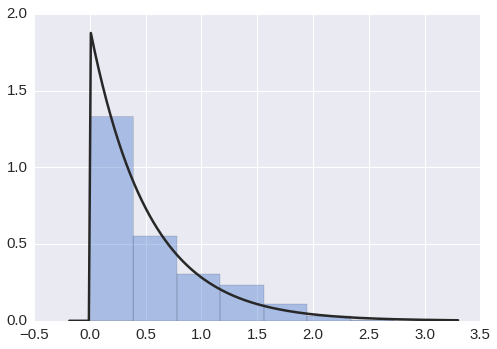

In [147]:
# one time analysis to re-bin volunme data
df = pd.read_csv('/home/kcavagnolo/ml_fun/telstra/data/log_feature_volume', index_col=0)
x = np.log10(df['volume'][(df.volume > 0)].values)
sns.distplot(x, bins=8, kde=False, fit=stats.expon)

# grab the bins in log space use the built-in Freedman-Diaconis rule
hist, bins = np.histogram(x, bins=8)

# assign each volume to a bin
inds = np.digitize(x, bins)

# add this to the df
df['volume'] = inds

# re-save
df.to_csv('/home/kcavagnolo/ml_fun/telstra/data/log_feature_class',index=False)

The event sev, evt, and res values can be coded into categoricals of 0/1 (one hot encode)

In [237]:
files

['/home/kcavagnolo/ml_fun/telstra/data/event_type.csv',
 '/home/kcavagnolo/ml_fun/telstra/data/log_feature.csv',
 '/home/kcavagnolo/ml_fun/telstra/data/resource_type.csv',
 '/home/kcavagnolo/ml_fun/telstra/data/severity_type.csv',
 '/home/kcavagnolo/ml_fun/telstra/data/test.csv',
 '/home/kcavagnolo/ml_fun/telstra/data/train.csv']

In [266]:
# set the train set as the master df on which to join everything
df = pd.read_csv(files[5], index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_train = df.copy()

df = pd.read_csv(files[4], index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_test = df.copy()

In [267]:
# let's work on the three files that are all categorical
# event_type, resource_type, severity_type
nfiles = [files[0], files[2], files[3]]

# iterate over files
for f in nfiles:
    df = pd.read_csv(f, index_col=0)
    for c in df.columns:
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
    dfv = pd.get_dummies(df).groupby(df.index).sum()
    df_train = df_train.join(dfv)
    df_test = df_test.join(dfv)

In [268]:
# let's work on the file that is not exactly categorical
# log_feature

# build a matrix of lfea that has values set to the volume
df = pd.read_csv(files[1])
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))

# keep track of unique values
codes = {}
vals = pd.unique(df['id'].values.ravel())
num = max(pd.unique(df['log_feature'].values.ravel().astype(int)))+1
cnames = ['lfea'+str(x) for x in range(1,num)]

# iterate over id's
for id in vals:
    x = [0]*num
    for i in df['log_feature'].loc[df['id'] == id].tolist():
        i = int(i)
        x[i] = int(df['volume'][(df['id'] == id) & (df['log_feature'] == str(i))])
    codes[id] = x

# dump to dataframe
df = pd.DataFrame.from_dict(codes, orient='index')
df = df.drop(0, 1)
df.columns = cnames

id              int64
log_feature    object
volume          int64
dtype: object


In [269]:
# gut check the 10005 entry from above
junk = df_train.join(df)
dft = junk.T
x = dft.loc[:, 10005] > 0
x[x].index

Index([u'location', u'event_type_11', u'event_type_13', u'event_type_14',
       u'resource_type_4', u'resource_type_6', u'resource_type_8',
       u'severity_type_1', u'lfea54', u'lfea345'],
      dtype='object')

Yep, those are all correct. So this is a good dataset now.

In [270]:
# join the log features
df_train = df_train.join(df)
df_test = df_test.join(df)

In [271]:
# check the df shape
print df_train.shape
df_train.head()

(7381, 456)


,location,fault_severity,event_type_1,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_17,...,lfea377,lfea378,lfea379,lfea380,lfea381,lfea382,lfea383,lfea384,lfea385,lfea386
id,,,,,,,,,,,,,,,,,,,,,
14121,118,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9320,91,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14394,152,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8218,931,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
14804,120,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [272]:
# check the df shape
print df_test.shape
df_test.head()

(11171, 455)


,location,event_type_1,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_17,event_type_18,...,lfea377,lfea378,lfea379,lfea380,lfea381,lfea382,lfea383,lfea384,lfea385,lfea386
id,,,,,,,,,,,,,,,,,,,,,
11066,481,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18000,962,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16964,491,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4795,532,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3392,600,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [273]:
# save to lrzipped hdf5 for easier loading later
df_test.to_hdf(datadir + 'test_features.h5', 'df')
!lrzip -zf /home/kcavagnolo/ml_fun/telstra/data/test_features.h5
!rm -f /home/kcavagnolo/ml_fun/telstra/data/test_features.h5

df_train.to_hdf(datadir + 'train_features.h5', 'df')
!lrzip -zf /home/kcavagnolo/ml_fun/telstra/data/train_features.h5
!rm -f /home/kcavagnolo/ml_fun/telstra/data/train_features.h5

Output filename is: /home/kcavagnolo/ml_fun/telstra/data/test_features.h5.lrz
/home/kcavagnolo/ml_fun/telstra/data/test_features.h5 - Compression Ratio: 249.570. Average Compression Speed:  4.333MB/s.
Total time: 00:00:08.12
Output filename is: /home/kcavagnolo/ml_fun/telstra/data/train_features.h5.lrz
/home/kcavagnolo/ml_fun/telstra/data/train_features.h5 - Compression Ratio: 231.844. Average Compression Speed:  4.333MB/s.
Total time: 00:00:05.59


# Reload the hdf5 file -- better starting point for future analysis.

In [274]:
!lrunzip -f /home/kcavagnolo/ml_fun/telstra/data/test_features.h5.lrz
!lrunzip -f /home/kcavagnolo/ml_fun/telstra/data/train_features.h5.lrz

df_test = pd.HDFStore(datadir+'test_features.h5')['df']
df_train = pd.HDFStore(datadir+'train_features.h5')['df']

Output filename is: /home/kcavagnolo/ml_fun/telstra/data/test_features.h5
Decompressing...

Average DeCompression Speed:  5.571MB/s
Output filename is: /home/kcavagnolo/ml_fun/telstra/data/test_features.h5: [OK] - 41843654 bytes                                
Total time: 00:00:07.09
Output filename is: /home/kcavagnolo/ml_fun/telstra/data/train_features.h5
Decompressing...
100%      26.77 /     26.77 MB
Average DeCompression Speed:  5.200MB/s
Output filename is: /home/kcavagnolo/ml_fun/telstra/data/train_features.h5: [OK] - 28071962 bytes                                
Total time: 00:00:04.80


## Attribute Summaries

In [279]:
# items to plot
a = ['eve', 'lfea', 'res', 'sev']

# build axes
mpl_fig = plt.figure()
ax1 = mpl_fig.add_subplot(411)
ax2 = mpl_fig.add_subplot(412)
ax3 = mpl_fig.add_subplot(413)
ax4 = mpl_fig.add_subplot(414)
axs = [ax1, ax2, ax3, ax4]

# iterate over each
for i, b in enumerate(a):
    y = df_train.filter(regex=b).apply(pd.value_counts).fillna(0).T[1]
    y = 100.*(y/df.shape[0])
    x = range(1,len(y)+1)
    axs[i].bar(x, y, label=a[i])
    axs[i].set_ylabel(a[i])
py.iplot_mpl(mpl_fig, strip_style=True)

In [280]:
# items to plot
a = ['eve', 'lfea', 'res', 'sev']

# build axes
mpl_fig = plt.figure()
ax1 = mpl_fig.add_subplot(411)
ax2 = mpl_fig.add_subplot(412)
ax3 = mpl_fig.add_subplot(413)
ax4 = mpl_fig.add_subplot(414)
axs = [ax1, ax2, ax3, ax4]

# iterate over each
for i, b in enumerate(a):
    y = df_test.filter(regex=b).apply(pd.value_counts).fillna(0).T[1]
    y = 100.*(y/df.shape[0])
    x = range(1,len(y)+1)
    axs[i].bar(x, y, label=a[i])
    axs[i].set_ylabel(a[i])
py.iplot_mpl(mpl_fig, strip_style=True)

## Feature Engineering
* Data has complex multi-dimensional structures that ML algos know how to find and exploit to make decisions
* You want to best expose those structures to the algo
* Some structures may be too dense or too complex for the algo to find without help (domain expertise comes into play here)
* Attribute decomposition into simpler components
* Attribute aggregation, e.g. hyperattributes

Any structure in the id sequencing, e.g. a time-series surrogate?

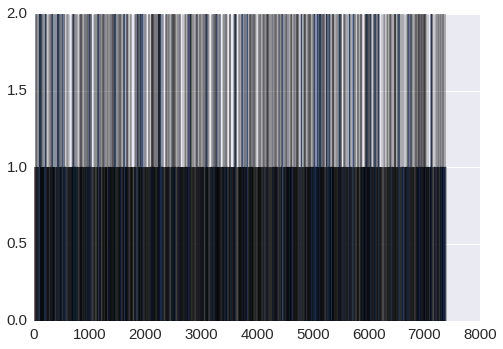

In [224]:
fault = df_train.fault_severity.astype(float)
n = len(fault)
plt.bar(np.arange(n), fault)
plt.show()

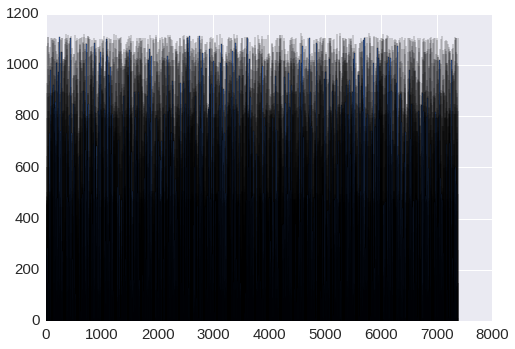

In [225]:
loc = df_train.location.astype(float)
plt.bar(np.arange(n), loc)
plt.show()

Both look like noise to me, gonna leave it for now. What about correlations among the various codes?

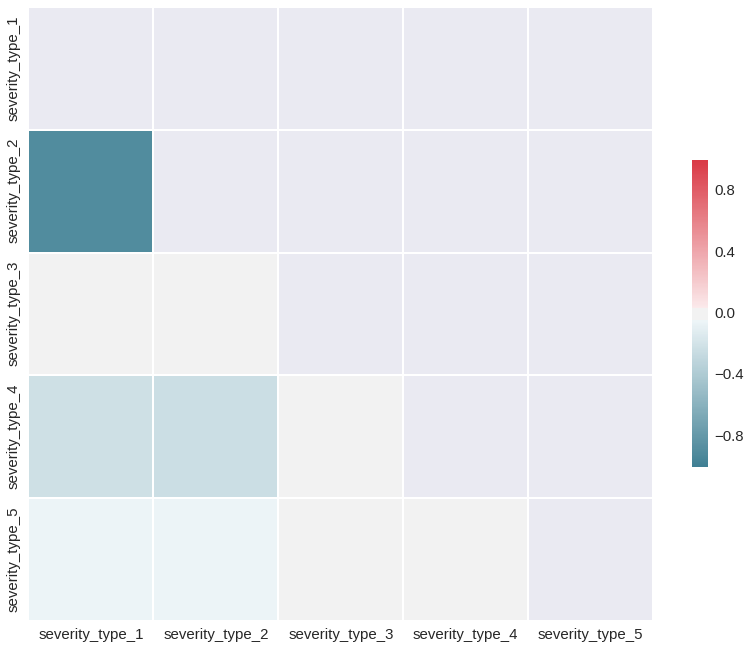

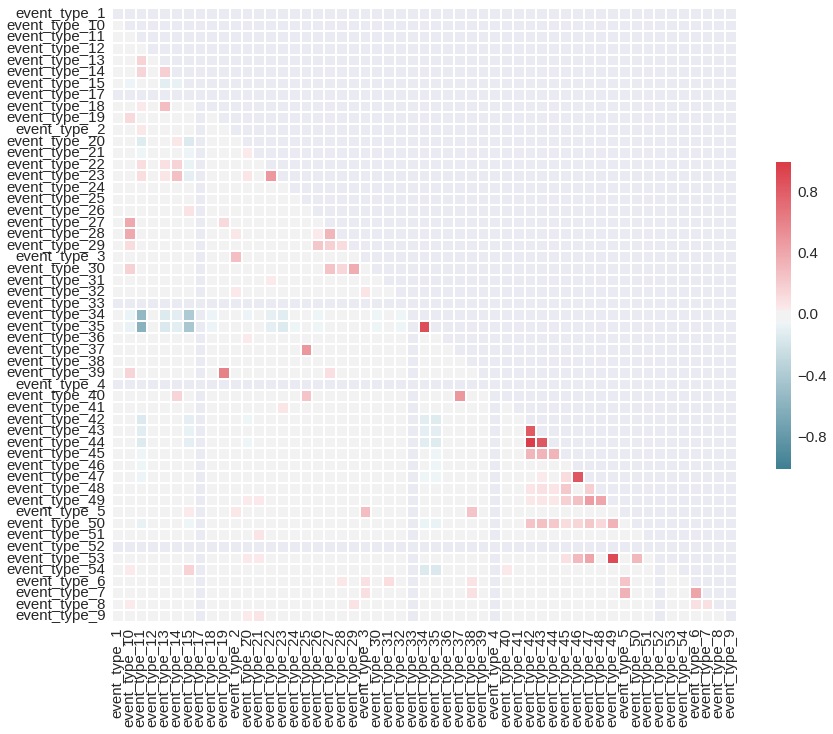

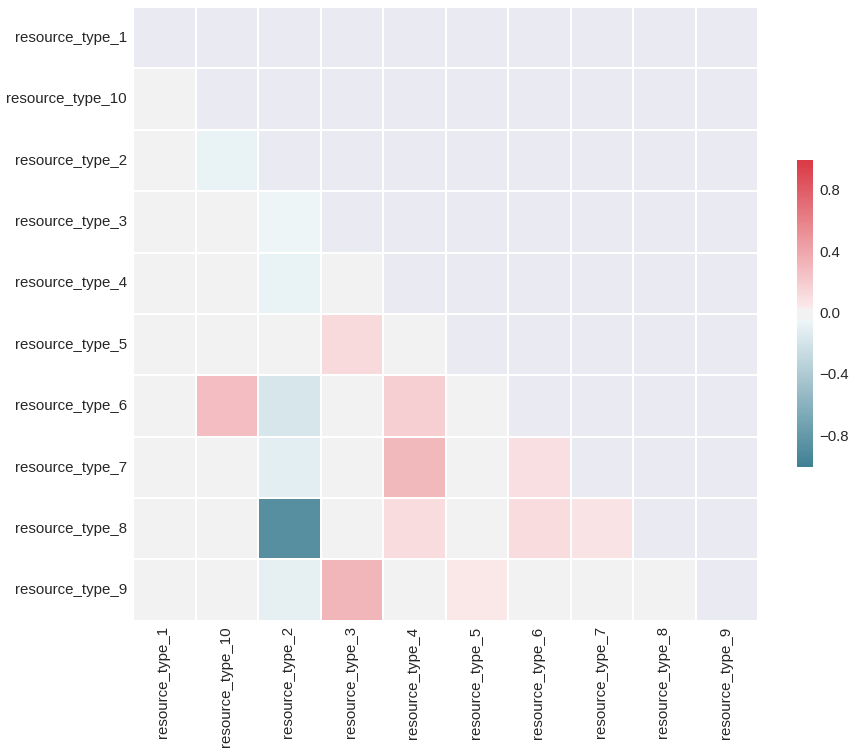

In [281]:
a = ['severity_type', 'event_type', 'resource_type']
for b in a:

    # Compute the correlation matrix
    corr = df_train.filter(regex=b).corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

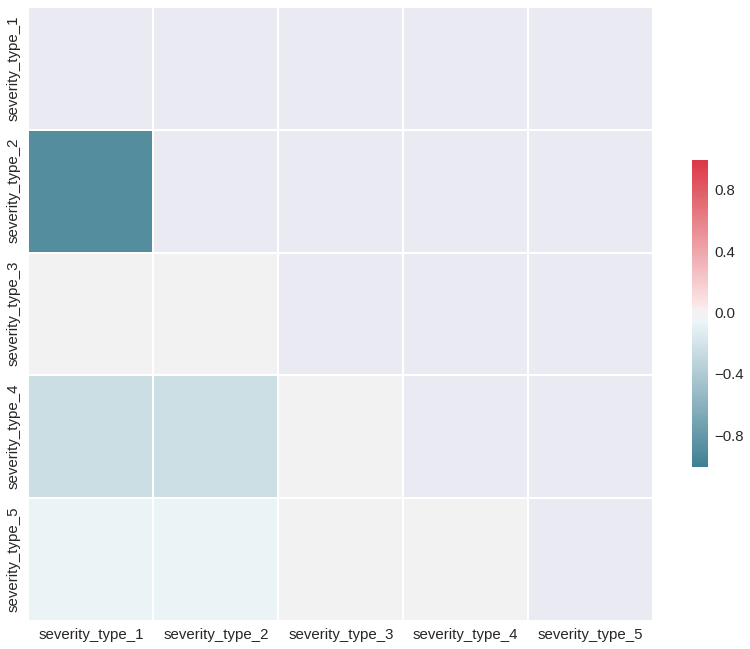

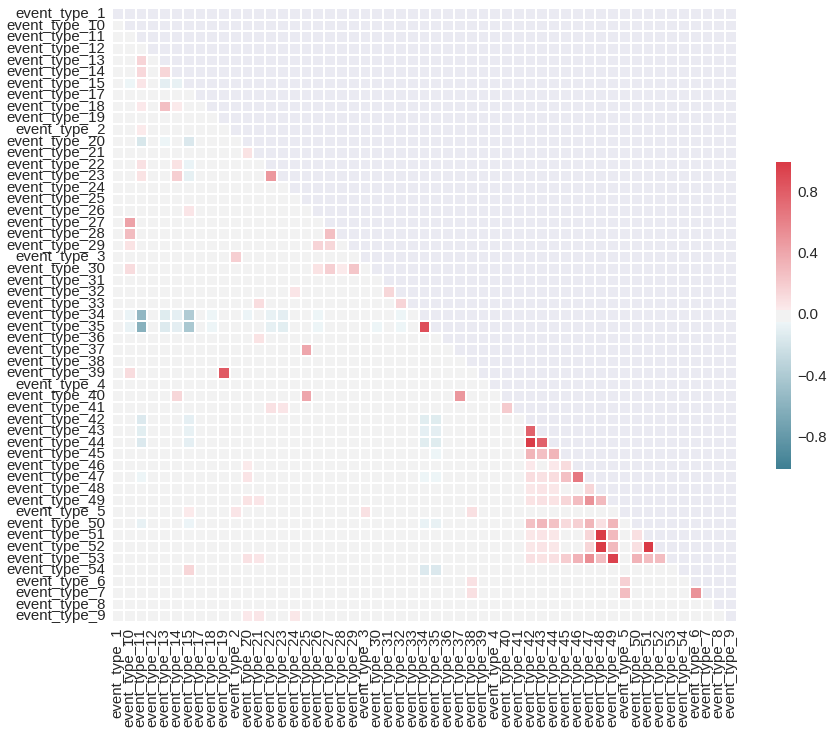

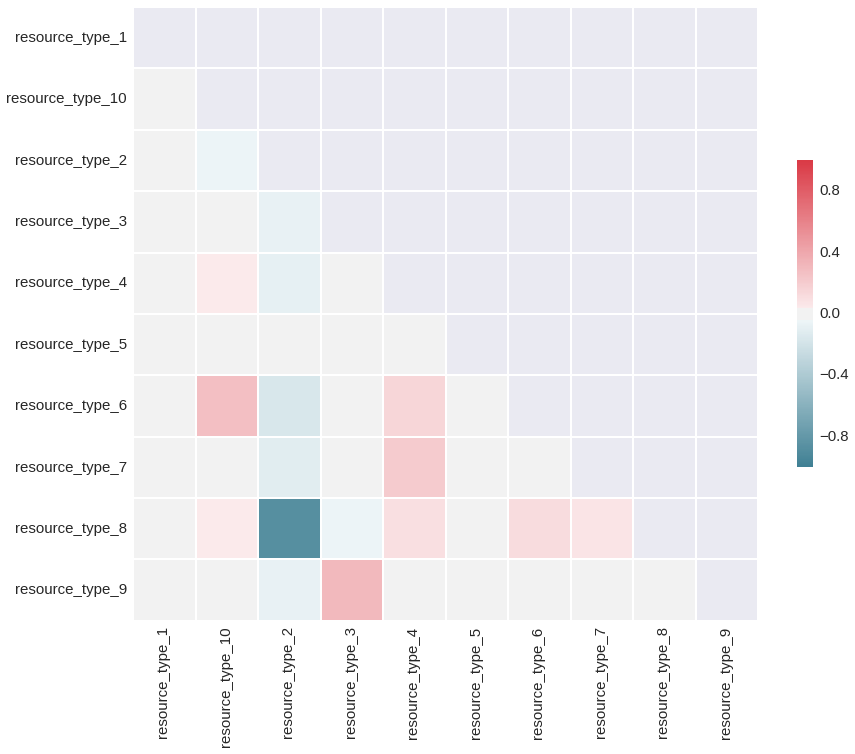

In [282]:
a = ['severity_type', 'event_type', 'resource_type']
for b in a:

    # Compute the correlation matrix
    corr = df_test.filter(regex=b).corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

The serverity types are anti-correlated as expected, and there is interesting structure in the resource and event types.

Makes me more curious about how these events are networked, i.e. communicating to each other? Build out as network problem? Can't: id and loc are 1:1 so the only connections will be among events that are the same, in that they have the same coding across all types. I don't see that as informative to a model.

## Clustering

However, clustering should be interesting: can add cluster membership as a new feature. Data is sparse matrix of binary and multiclass values, options for analysis:
* binary Jaccard similarity distance and [score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_similarity_score.html)
* K-mode clustering
* Cosine Distance (and other sparse text vectors)
* dissimilarity matrix

For k-means, see the odot ipynb, which isn't relevant here since this is categorical data (0/1) and Euclidean distance (used for clustering in k-menas) will be meaningless.

In [284]:
# preprocess
from sklearn import preprocessing

# re-scale location to reduce it's weight
minmax = preprocessing.MinMaxScaler()
df2 = df_train.copy()
a = df2.location
df2['location'] = minmax.fit_transform(a)

In [335]:
# save X, y, and feature names
y      = df2.fault_severity.as_matrix()
df_l   = df2.copy
df_nl  = df2.drop('location', 1).copy()
fea_l  = df2.drop('fault_severity', axis=1).columns
fea_nl = df2.drop('fault_severity', axis=1).drop('location', 1).columns
X_l    = df2.drop('fault_severity', 1).as_matrix().astype(np.float)
X_nl   = df2.drop('fault_severity', 1).drop('location', 1).as_matrix().astype(np.float)

# checks
print "%d observations of %d features (loc)" % X_l.shape
print "%d observations of %d features (noloc)" % X_nl.shape
print "Unique labels:", np.unique(y)

7381 observations of 455 features (loc)
7381 observations of 454 features (noloc)
Unique labels: [0 1 2]


In [307]:
# temp train/test split
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD

# reduce dims
X_lred = TruncatedSVD(n_components=25).fit_transform(X_l)
X_nlred = TruncatedSVD(n_components=25).fit_transform(X_nl)

# split data
X_ltrain, X_ltest, y_train, y_test = train_test_split(X_lred, y, test_size=0.3)
X_nltrain, X_nltest, y_train, y_test = train_test_split(X_nlred, y, test_size=0.3)

# check for struc in tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
xl = tsne.fit_transform(X_ltest)
xnl = tsne.fit_transform(X_nltest)

In [308]:
# plot the result
mpl_fig = plt.figure()
vis_x = xl[:, 0]
vis_y = xl[:, 1]
sns.regplot(vis_x, vis_y,
           fit_reg=False,
           scatter=True,
           scatter_kws={"c": y_test,
                        "cmap": plt.cm.jet,
                        "label": y_test}
           )
plt.title('t-SNE (w/ location)')
plt.xlabel('P1')
plt.ylabel('P2')
py.iplot_mpl(mpl_fig, strip_style=True)

In [309]:
# plot the result
mpl_fig = plt.figure()
vis_x = xnl[:, 0]
vis_y = xnl[:, 1]
sns.regplot(vis_x, vis_y,
           fit_reg=False,
           scatter=True,
           scatter_kws={"c": y_test,
                        "cmap": plt.cm.jet,
                        "label": y_test}
           )
plt.title('t-SNE (w/o location)')
plt.xlabel('P1')
plt.ylabel('P2')
py.iplot_mpl(mpl_fig, strip_style=True)

This... is not obvious. But the clustering of high fault events looks clearer without location.

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2579, cost: 29924.0
Run 1, iteration: 2/100, moves: 265, cost: 29496.0
Run 1, iteration: 3/100, moves: 91, cost: 29449.0
Run 1, iteration: 4/100, moves: 6, cost: 29449.0
(0, 3682)
(1, 3)
(2, 25)
(3, 32)
(4, 2)
(5, 232)
(6, 44)
(7, 1)
(8, 182)
(9, 23)
(10, 3)
(11, 175)
(12, 49)
(13, 236)
(14, 1990)
(15, 257)
(16, 286)
(17, 2)
(18, 10)
(19, 147)


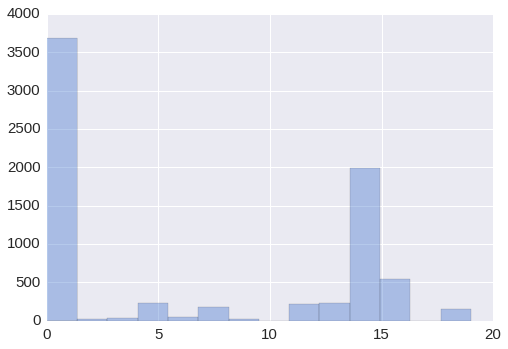

In [315]:
from kmodes import kmodes
from collections import Counter

# build the clusters
km = kmodes.KModes(n_clusters=20, init='Cao', n_init=5, verbose=1)
clusters = km.fit_predict(X_nl)

# viz the cluster dist
for i in Counter(clusters).items():
    print i
sns.distplot(clusters, kde=False)

That's not a terrible result, it somewhat mimics the tsne result, except for bins 3 and 4, as I don't see any isolated points in tsne, but it's not a 1:1 comparison. Let's see how this performs. First add the cluster assignments to the X matrix.

In [111]:
# append cluster membership to the no-location version of X
a = np.array(clusters)[np.newaxis]
print 'X no loc ', X_nl.shape
X_nlc = np.concatenate((X_nl, a.T), axis=1)
print 'X no loc+clu ', X_nlc.shape

X no loc  (7381, 454)
X no loc+clu  (7381, 455)


# Algorithm Evaluation

## Experiments

### Theano

In [112]:
#quick existing model test
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
thno.config.compute_test_value = 'warn'

batch_size = 128
nb_epoch = 20

# rebuild the train and test sets
X_nlctrain, X_nlctest, y_train, y_test = train_test_split(X_nlc, y, test_size=0.2)

X_train = X_nlctrain.astype('float32')
X_test = X_nlctest.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 3).astype('float32')
Y_test = np_utils.to_categorical(y_test, 3).astype('float32')

print X_train.shape[0], 'train samples'
print X_test.shape[0], 'test samples'
dims = X_nlc.shape[1]

model = Sequential()

model.add(Dense(512, input_shape=(dims,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(3))
model.add(Activation('softmax'))

rms = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=rms)

model.fit(X_train, Y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          show_accuracy=True,
          verbose=2,
          validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test,
                       show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

5904 train samples
1477 test samples


### Scikit

Going to build test harness of test, train, and validation splits using KFolding. Then run predicitions for each fold. Also want to keep track of true positive rate (tpr) and false positive rate (fpr) so I can evaluate receiving operating characteristic curves (ROC's) and the associated area under the curve (AUC) of each. I will also plot the confusion matrix for each model to visualize the predicitve results.

Define the cross-validation and confusion matrix helper functions.

In [333]:
# load scikit harness
from sklearn import metrics
from sklearn.cross_validation import KFold

# build a cross-validation function
def run_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=10, shuffle=True)
    y_pred = y.copy()
    #mean_tpr = 0.0
    mean_acc = 0.0
    mean_prec = 0.0
    mean_recl = 0.0
    mean_f1 = 0.0
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
        mean_acc += metrics.accuracy_score(y[test_index], y_pred[test_index])
        mean_recl += metrics.recall_score(y[test_index], y_pred[test_index])
        mean_prec += metrics.precision_score(y[test_index], y_pred[test_index])
        mean_f1 += metrics.f1_score(y[test_index], y_pred[test_index])
    mean_acc /= len(kf)
    mean_recl /= len(kf)
    mean_prec /= len(kf)
    mean_f1 /= len(kf)
    return y_pred, mean_acc, mean_prec, mean_recl, mean_f1

def draw_confusion_matrices(confusion_matrices, class_names):
    labels = list(class_names)
    for cm in confusion_matrices:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm[1])
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.title('%s' % cm[0])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        for i,j in ((x,y) for x in xrange(len(cm[1])) for y in xrange(len(cm[1][0]))):
            val = '{:.1%}'.format(cm[1][i][j]/cm[1].sum())
            ax.annotate(str(val), xy=(i,j), color='white', ha="center", va="center")
        plt.show()

Loading up a bunch of standard machine learning algorithms into test harness. This is a classification problem, so let's try the standard models...

In [337]:
from xgboost import XGBClassifier as XGBC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as ARF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import BernoulliRBM as RBM
from sklearn.tree import DecisionTreeClassifier as DT

# accuracy tests for some models
ml_models = []
#ml_models.append(["XGBoost", XGBC, {'max_depth':3, 'n_estimators':300, 'learning_rate':0.05}])
#ml_models.append(["Support Vector Machine", SVC, {}])
ml_models.append(["Linear Logistic Regression", LR, {'multi_class':'multinomial',
                                                     'solver':'lbfgs'}])
ml_models.append(["Naive Bayes", NB, {}])
ml_models.append(["Decision Trees", DT, {}])
ml_models.append(["Random Forest", RF, {'n_estimators':200,
                                        'min_samples_split':2, 'n_jobs':-1}])

### Measure Performance

Show me the accuracy (acc), precision (prec), recall (recl), confusion matrix (cm), and mean auc for each model.

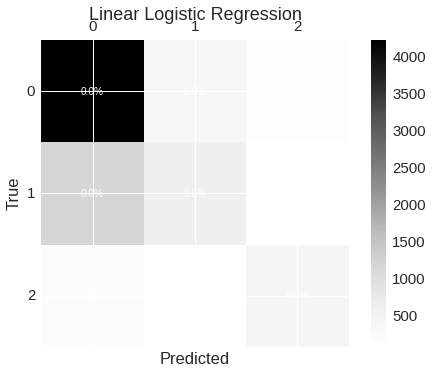

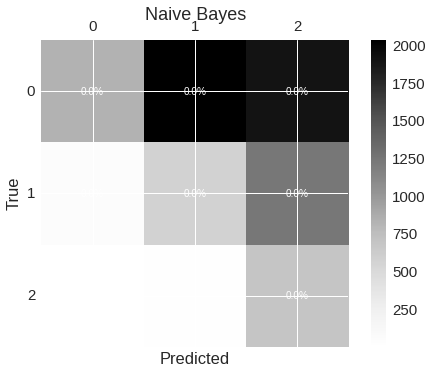

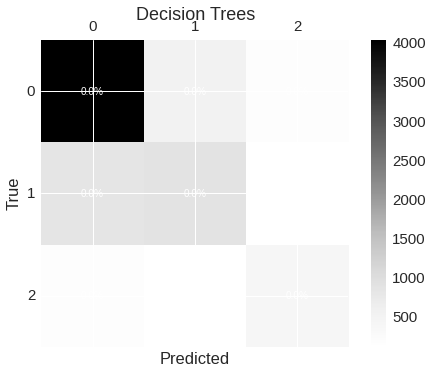

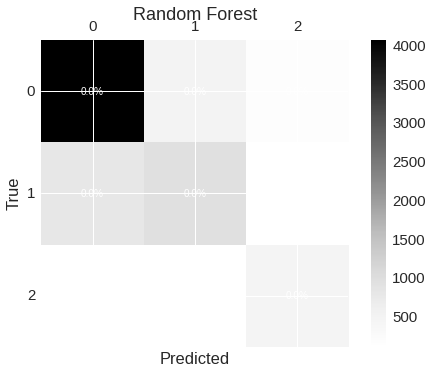

In [338]:
# process each model
models = []
acc = []
prec = []
recl = []
f1 = []
cms = []
aucs = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X_nl, y, m[1], **m[2])
    models.append(m[0])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))

# plot confusion matricies
draw_confusion_matrices(cms, np.unique(y))

In [339]:
models_df = pd.DataFrame.from_items([('model', models),
                              ('accuracy', acc),
                              ('precision', prec),
                              ('recall', recl),
                              ('f1', f1)
                              ])
models_df.sort(['accuracy', 'precision', 'recall', 'f1'], ascending=[False, False, False, False])

,model,accuracy,precision,recall,f1
3,Random Forest,0.744887,0.739185,0.744887,0.740260
2,Decision Trees,0.726189,0.718148,0.726189,0.720118
0,Linear Logistic Regression,0.713591,0.691811,0.713591,0.690937
1,Naive Bayes,0.285870,0.677169,0.285870,0.285611


### Testing Results

Find which of the harness models has performed the best in the first pass.

In [341]:
# best and worst models
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])

max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])

max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

Best accuracy:       Random Forest        74.49%
Best precision:      Random Forest        73.92%
Best recall:         Random Forest        74.49%


Random forest is the obvious winner by all measures, so let's take a crack at tuning that model.

## Algorithm Tuning

### Question: What are the important features in the model, and does the model improve when using those features only?

In [197]:
# feature importance
kf = KFold(len(y), n_folds=10, shuffle=True, random_state=4)
y_pred = y.copy()

# keep values for all features
feat_impt = {}
for f in features:
    feat_impt[f] = []

# go through all features    
for train_index, test_index in kf:
    clf = RF(n_estimators=50, min_samples_split=2, n_jobs=-1)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred[test_index] = clf.predict(X_test)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        feat_impt[features[indices[f]]].append(importances[indices[f]])

for k in feat_impt:
    val = np.mean(feat_impt[k])
    std = np.std(feat_impt[k])
    feat_impt[k] = val

In [209]:
# sort the features by importance
sorted_feat = sorted(feat_impt.items(), key=operator.itemgetter(1))
sorted_feat.reverse()

# bookkeeping
cumper = 0.
nbr = False

# make a copy of original dataframe to drop unneeded features
X_keep = df_nl.copy()

# print out importances
print "item -- feature -- weight -- cumm_weight"
for i, k in enumerate(sorted_feat):
    cumper += k[1]
    
    # tell me when we hit 90% of weights
    if (nbr is False and cumper >= 0.95):
        print '**----  Reached 95%  ----**'
        nbr = True
    print i, k[0], '{:.1%}'.format(k[1]), '{:.0%}'.format(cumper)
    
    # drop unneeded features
    if nbr is True:
        X_keep = X_keep.drop(k[0], axis=1)

item -- feature -- weight -- cumm_weight
0 lfea203 14.1% 14%
1 lfea82 7.2% 21%
2 lfea170 3.5% 25%
3 lfea312 2.6% 27%
4 lfea54 2.4% 30%
5 lfea71 2.3% 32%
6 lfea80 2.2% 34%
7 event_type_15 2.0% 36%
8 lfea232 1.9% 38%
9 lfea68 1.8% 40%
10 lfea193 1.8% 42%
11 severity_type_1 1.8% 44%
12 lfea201 1.7% 45%
13 event_type_35 1.6% 47%
14 resource_type_2 1.4% 48%
15 resource_type_8 1.3% 50%
16 lfea73 1.3% 51%
17 lfea313 1.2% 52%
18 severity_type_2 1.2% 53%
19 lfea307 1.0% 54%
20 lfea227 1.0% 55%
21 lfea315 0.9% 56%
22 event_type_11 0.9% 57%
23 lfea195 0.9% 58%
24 lfea233 0.9% 59%
25 event_type_34 0.9% 60%
26 event_type_54 0.8% 61%
27 lfea202 0.8% 61%
28 lfea209 0.7% 62%
29 lfea273 0.7% 63%
30 lfea171 0.7% 63%
31 lfea283 0.6% 64%
32 lfea81 0.6% 65%
33 lfea155 0.6% 65%
34 lfea55 0.6% 66%
35 lfea291 0.6% 67%
36 lfea179 0.6% 67%
37 severity_type_4 0.6% 68%
38 lfea314 0.6% 68%
39 lfea219 0.6% 69%
40 lfea70 0.6% 69%
41 lfea235 0.5% 70%
42 lfea134 0.5% 71%
43 lfea223 0.5% 71%
44 lfea376 0.5% 72%
45 lfea

In [210]:
# get names of all features in new df
X_keep = X_keep.drop('fault_severity', axis=1)
features_keep = X_keep.columns
X_keep = X_keep.as_matrix().astype(np.float)

# checks
print "\n%d observations of %d features" % X_keep.shape
print "Unique labels:", np.unique(y)
print "Gut-check features: %i" % len(features_keep)


7381 observations of 157 features
Unique labels: [0 1 2]
Gut-check features: 157


Re-run the ML test harness for RF only and see if the model improves (below is cut and paste of earlier code)

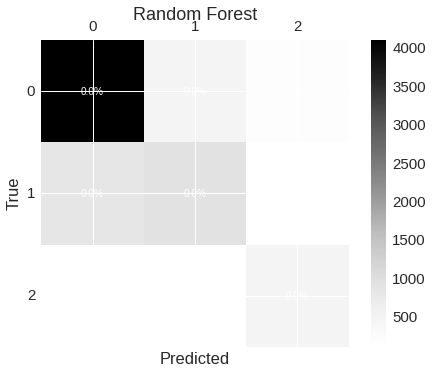

Best accuracy:       Random Forest        74.65%
Best precision:      Random Forest        73.95%
Best recall:         Random Forest        74.65%


In [212]:
ml_models = []
ml_models.append(["Random Forest", RF, {'n_estimators':72,
                                        'min_samples_split':9,
                                        'n_jobs':-1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X_keep, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))

draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

* RF predictive power got worse when features contributing < 10% weight were dropped.
* **RF predictive power got better when features contributing < 5% weight were dropped.**

### Question: But is RF superior in its calibration and discrimination?

Calibration measures the difference between actual and predicted probability for individual groups. Discrimination measures the difference between model predictions and the baseline probability. Equations are taken from [Yang, Yates, and Smith (1991)](http://psychology.huji.ac.il/.upload/Ilan/YanivYatesSmith1991PB.pdf).

In [222]:
from operator import idiv

def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=10, shuffle=True)
    y_prob = np.zeros((len(y), 3))
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf.fit(X_train,y_train)
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

def calibration(prob, outcome,n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    c = 0.0
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        predicted_prob = np.mean(prob[in_bin])
        true_bin_prob = np.mean(outcome[in_bin])
        c += np.sum(in_bin) * ((predicted_prob - true_bin_prob) ** 2)
    return c / len(prob)

def discrimination(prob, outcome, n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    d = 0.0
    base_prob = np.mean(outcome)
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        true_bin_prob = np.mean(outcome[in_bin])
        d += np.sum(in_bin) * ((true_bin_prob - base_prob) ** 2)
    return d / len(prob)

In [234]:
print "Lower calibration and higher discrimination are preferred..."

ml_models = []
#ml_models.append(["XGBoost", XGBC, {'max_depth':3, 'n_estimators':300, 'learning_rate':0.05}])
#ml_models.append(["Support Vector Machine", SVC, {}])
ml_models.append(["Linear Logistic Regression", LR, {'multi_class':'multinomial',
                                                     'solver':'lbfgs'}])
ml_models.append(["Naive Bayes", NB, {}])
ml_models.append(["Decision Trees", DT, {}])
ml_models.append(["Random Forest", RF, {'n_estimators':200,
                                        'min_samples_split':2, 'n_jobs':-1}])

cal_err = []
discrim = []
for m in ml_models:
    print "\n"+m[0]
    pred_prob = run_prob_cv(X, y, m[1], **m[2])
    churn_prob, is_churn = pred_prob[:,1], y == 1
    cal_err.append(calibration(churn_prob, is_churn))
    discrim.append(discrimination(churn_prob,is_churn))
    print '{:20} {:.4f}'.format("Calibration Error", cal_err[-1])
    print '{:20} {:.4f}'.format("Discrimination", discrim[-1])
    
idx, value = min(enumerate(cal_err), key=operator.itemgetter(1))
print '{:20} {:20} {:.3%}'.format('\nBest calibration error:', ml_models[idx][0], cal_err[idx])
idx, value = max(enumerate(discrim), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best discrimination:', ml_models[idx][0], discrim[idx])

Lower calibration and higher discrimination are preferred...

Linear Logistic Regression
Calibration Error    0.0000
Discrimination       0.0000

Naive Bayes
Calibration Error    0.2523
Discrimination       0.0006

Decision Trees
Calibration Error    0.0241
Discrimination       0.0099

Random Forest
Calibration Error    0.0002
Discrimination       0.0004

Best calibration error: Linear Logistic Regression 0.000%
Best discrimination: Decision Trees       0.99%


### Question: Can we tune the model params to get better results?

In [235]:
from operator import itemgetter

def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [236]:
from time import time
from sklearn.grid_search import GridSearchCV

clf = RF(n_jobs=-1)
param_grid = {"n_estimators":[50, 75, 100],
              "max_depth": [None, 3],
              "max_features": [None, 'auto'],
              "min_samples_split": [4, 9],
              "min_samples_leaf": [1],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

KeyboardInterrupt: 

**Best scores using X (took 542.40 seconds for 32 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.009)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.955 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}


**Best scores using X_keep (took 471.68 seconds for 48 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.957 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

In [ ]:
ml_models = []
ml_models.append(["Random Forest", RF, {'bootstrap': True,
                                        'min_samples_leaf': 1,
                                        'n_estimators': 500,
                                        'min_samples_split': 4,
                                        'criterion': 'entropy',
                                        'max_features': 'auto',
                                        'max_depth': None,
                                        'n_jobs': -1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))
draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

**This model is hardly better than the initial guess, but it's technically simpler, so I'll run with this one.**

In [ ]:
# Use 10 estimators so predictions are all multiples of 0.1
m = (["Random Forest", RF, {'bootstrap': True,
                            'min_samples_leaf': 1,
                            'n_estimators': 10,
                            'min_samples_split': 1,
                            'criterion': 'entropy',
                            'max_features': 'auto',
                            'max_depth': None,
                            'n_jobs': -1}])
pred_prob = run_prob_cv(X, y, m[1], **m[2])
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

In [ ]:
from ggplot import *
baseline = np.mean(is_churn)
ggplot(counts, aes(x='pred_prob',y='true_prob',size='count')) + \
        geom_point(color='blue') + \
        stat_function(fun = lambda x: x, color='red') + \
        stat_function(fun = lambda x: baseline, color='green') + \
        xlim(-0.05,  1.05) + \
        ylim(-0.05,1.05) + \
        ggtitle("Random Forest") + \
        xlab("Predicted probability") + ylab("Relative frequency of outcome")

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------
# Stuff below is collected junk that might be used.

In [ ]:
import xgboost as xgb
x_train_xgb = x_train.as_matrix()
y_train_xgb = y_train.as_matrix()
model = xgb.XGBClassifier()
model.fit(x_train_xgb, y_train_xgb)
y_probs = model.predict_proba(x_test.as_matrix())
print(y_probs)

final = [[iden,(y_probs[j][0]),(y_probs[j][1]),(y_probs[j][2])] for j,iden in enumerate(testUniqueIds)]
frame = pd.DataFrame(final,columns=('id','predict_0','predict_1','predict_2'))
frame.to_csv("submission.csv",index=False)

In [ ]:
# build random forest
clf = RandomForestClassifier(n_estimators=50, oob_score=True)  
n_trials = 100
test_size_percent = 0.1

# build labels
sig_field = 'sms_count'
signals = df[[c for c in df.columns if c != sig_field]]
labels = df[sig_field]

# test train split
plot_data = []
for trial in range(n_trials):
    train_signals, test_signals, train_labels, test_labels = train_test_split(
                                                            signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)  
    thresholds = np.append(thresholds, 1)
    queue_rate = []  
    for threshold in thresholds:  
        queue_rate.append((predictions >= threshold).mean())
        
    # save plot data
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })
    
# plot model
uniform_thresholds = np.linspace(0, 1, 101)
uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []
for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

quantiles = [0.1, 0.5, 0.9]  
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)  
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)  
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)  
plt.plot(uniform_thresholds, median_recall)  
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])  
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])  
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

uniform_payout_plots = []
n = 10000  
success_payoff = 100  
case_cost = 20

for p in plot_data:  
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)
    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])  
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]  
plt.vlines([max_ap], -100000, 150000, linestyles='--')  
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('$')  
plt.title("Payout as a Function of Threshold")

print '{0:.0f}'.format(np.max(median_payout))